In [1]:
""" 
Importing the models
"""
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
"""
Keeping track of constants for consistency
"""
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.1
SEED = 123

### Loading the data and the model

In [3]:
def load_data():
    """
    Importing the dataset into the model
    """

    # Image batch: (64, 256, 256, 3)
    # Labels batch: (64, 10)

    # train
    # train_ds = tf.keras.utils.image_dataset_from_directory(
    #     "data/concatenated_datasets",
    #     validation_split=VALIDATION_SPLIT,
    #     subset="training",
    #     seed=SEED,
    #     batch_size=BATCH_SIZE,
    #     label_mode="categorical",
    # )

    # # dev
    # dev_ds = tf.keras.utils.image_dataset_from_directory(
    #     "data/concatenated_datasets",
    #     validation_split=VALIDATION_SPLIT,
    #     subset="validation",
    #     seed=SEED,
    #     batch_size=BATCH_SIZE,
    #     label_mode="categorical",
    # )

    # dev
    dev_ds = tf.keras.utils.image_dataset_from_directory(
        "data/grape_plantvillage_dataset",
        # validation_split=0.999,
        # subset="validation",
        seed=SEED,
        batch_size=BATCH_SIZE,
        label_mode="categorical",
    )


    normalization_layer = layers.Rescaling(1.0 / 255)
    # train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    dev_ds = dev_ds.map(lambda x, y: (normalization_layer(x), y))

    return None, dev_ds

train_ds, dev_ds = load_data()

Found 4068 files belonging to 10 classes.


In [4]:
def init_model():
    """
    Making the actual model
    """

    # weights_path = "/scratch/st-sielmann-1/agrobot/grape-ld/pretrained_weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
    pre_trained_model = InceptionV3(
        input_shape=(256, 256, 3), include_top=False, weights='imagenet'
    )

    for layer in pre_trained_model.layers:
        layer.trainable = False

    x = layers.Flatten()(pre_trained_model.output)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(10, activation="softmax")(x)

    model = Model(pre_trained_model.input, x)
    model.compile(
        optimizer=RMSprop(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )
    
    return model

model = init_model()

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalization[0][0

In [5]:
"""
Loading the model weights. 
Note: Change checkpoint path to your path, and also you should have a .ckpt.index file and a .ckpt.data file
"""
checkpoint_path = "training/model"
model.load_weights(checkpoint_path)

### Displaying the confusion matrix for error analysis

In [6]:
""" 
This is for the confusion matrix on the cross validation set
"""
# model.predict(dev_ds)

predicted_dev_classes = np.array([])
true_dev_classes =  np.array([])

for x, y in dev_ds:
    predicted_dev_classes = np.concatenate([predicted_dev_classes, np.argmax(model.predict(x), axis=-1)])
    true_dev_classes = np.concatenate([true_dev_classes, np.argmax(y.numpy(), axis=-1)])

2/2 [==============================] - 3s 373ms/step


In [15]:
with open("cache/predicted_dev_classes.npy", 'wb') as f:
    np.save(f, predicted_dev_classes)

with open("cache/true_dev_classes.npy", 'wb') as f:
    np.save(f, true_dev_classes)

In [16]:
predicted_dev_classes = open("cache/predicted_dev_classes.npy", 'rb')
true_dev_classes = open("cache/true_dev_classes.npy", 'rb')
predicted_dev_classes = np.load(predicted_dev_classes)
true_dev_classes = np.load(true_dev_classes)

In [7]:
score = model.evaluate(dev_ds, verbose=0)
print(score)

[0.02238721214234829, 0.9972959756851196]


In [9]:
print(model.metrics_names)
print(score)

['loss', 'acc']
[0.02238721214234829, 0.9972959756851196]


In [17]:
confusion_matrix = tf.math.confusion_matrix(true_dev_classes, predicted_dev_classes)

class_names = ['BlackRot', 'DownyMildew', 'ESCA', 'GrayMold', 'Healthy', 'LeafBlight', 'MosaicVirus', 'Pierce', 'PowderyMildew', 'SourRot']

Text(0.5, 1.0, 'Model Accuracy Score: 99.73%')

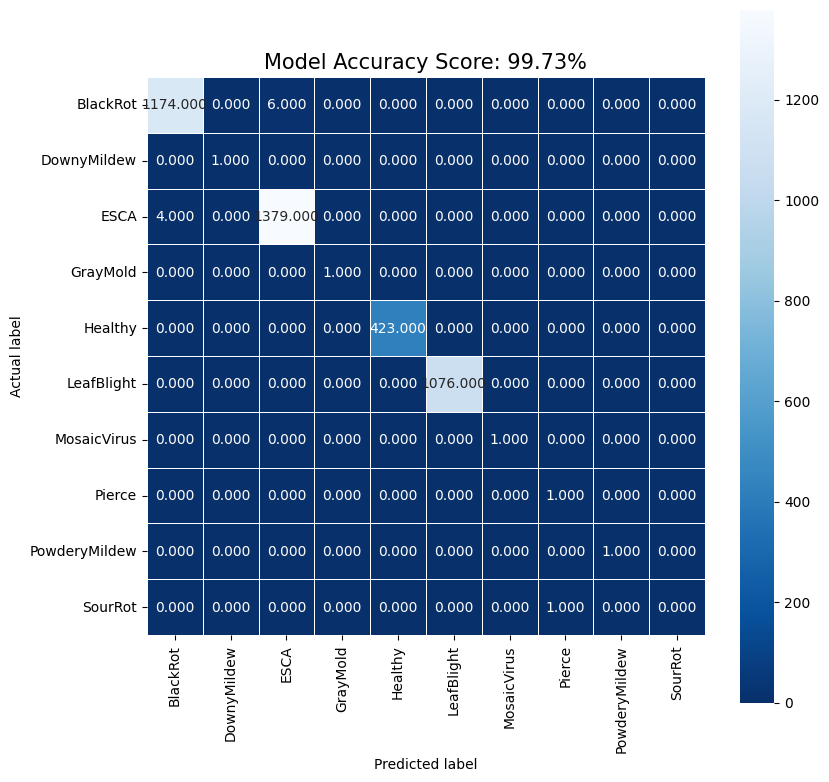

In [18]:
""" 
Displaying the confusion matrix
"""
plt.figure(figsize=(9,9))
seaborn.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {score[1]:.2%}'
plt.title(all_sample_title, size = 15)

### Evaluating the model on webscraped images

1. Clean the images of None images
2. Load the dataset
3. Get the predictions
4. Display the confusion matrix

In [11]:
"""
This is for cleaning the webscraped images.
IGNORE THIS. 
"""

from pathlib import Path
import imghdr

data_dir = "webscrape/PowderyMildew"
image_extensions = [".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            os.system(f"rm {filepath}")
        elif img_type not in img_type_accepted_by_tf:
            os.system(f"rm {filepath}")


In [12]:
"""
This is for loading the webscraped images
IGNORE THIS. 
"""
eval_ds = tf.keras.utils.image_dataset_from_directory(
    "webscrape",
    seed=SEED,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)
normalization_layer = layers.Rescaling(1.0 / 255)
eval_ds = eval_ds.map(lambda x, y: (normalization_layer(x), y))


Found 623 files belonging to 2 classes.


In [13]:
"""
IGNORE THIS. 
"""
# model.predict(dev_ds)

predicted_eval_classes = np.array([])
true_eval_classes =  np.array([])

for x, y in eval_ds:
    predicted_eval_classes = np.concatenate([predicted_eval_classes, np.argmax(model.predict(x), axis=-1)])
    true_eval_classes = np.concatenate([true_eval_classes, np.argmax(y.numpy(), axis=-1)])

2024-02-17 11:44:23.578127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-17 11:44:23.606661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-17 11:44:23.715307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-02-17 11:44:24.177343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-02-17 11:44:24.190193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-02-17 11:44:24.340707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-17 11:44:26.390234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-17 11:44:27.793045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 3s 825ms/step


In [14]:
"""
Finding the accuracy of the webscraped images
IGNORE THIS. 
"""
total = 0
correct = 0
for i in range(len(true_eval_classes)):
    if true_eval_classes[i] == predicted_eval_classes[i]:
        correct += 1
    total += 1

print(correct / total)

0.22150882825040127
